# Imports, setting up device and seeds

In [107]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
 
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import torch.optim as optim

from torch.utils.data import DataLoader, random_split

In [108]:
import os
import random

def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_all_seeds(42)

In [109]:
# torch.cuda.set_device(1)
device = torch.device("cuda")
# device = torch.device('tpu')
# device = torch.device('cpu')

# Constants

In [110]:
VALIDATION_PERCENTAGE = 0.10
TRAIN_PATH = "/kaggle/input/traffic/trafic_32"

# Loading data

In [111]:
%%time
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainFolder = torchvision.datasets.ImageFolder(root=TRAIN_PATH,
                                               transform=transform)

n_val = int(np.floor(VALIDATION_PERCENTAGE * len(trainFolder)))
n_train = len(trainFolder) - n_val

train_ds, val_ds = random_split(trainFolder, [n_train, n_val])

trainloader = DataLoader(train_ds, batch_size=batch_size, drop_last=True, shuffle=True)
validloader = DataLoader(val_ds , batch_size=batch_size, drop_last=True, shuffle=True)

CPU times: user 956 ms, sys: 1.27 s, total: 2.23 s
Wall time: 27.2 s


In [112]:
next(iter(trainloader))[0].max()

tensor(1.)

In [113]:
# takes images from valid dataset
def get_train_images(num):
    return torch.stack([val_ds[i][0] for i in range(10,10+num)], dim=0)

# Model

In [114]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear(hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x       = self.LeakyReLU(self.fc_1(x))
        x       = self.LeakyReLU(self.fc_2(x))
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)                      # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [115]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))
        
        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat

In [116]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

        
    def reparameterization(self, mean, var):
        eps = torch.randn_like(mean)
        z = eps * var + mean
        # z = np.random.normal(mean, var)
        # z = mean # Change to proper sampling
        return z
        
                
    def forward(self, x):
        mean, log_var = self.encoder(x)
#         print("mean log_var", mean.shape, log_var.shape)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
#         print("z", z.shape)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [117]:
vae = VAE(latent_dim=64, hidden_dim=1024, x_dim=32*32*3).to(device)

# Training loop

In [118]:
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [119]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss+ KLD

In [120]:
%%time
num_epochs = 15
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(trainloader):
        x = x.to(device)
#         print("X SHAPE: ", x.shape, x.shape[0])
        out, means, log_var = vae(x)
        out = out.cpu()
        x = x.cpu()
#         out = x.view (x.shape[0],3,32,32)
#         print("OUT SHAPE: ", out.shape)
#         print("X SHAPE: ", x.shape)
        loss = vae_loss_function(x, out, means, log_var)
        losses_epoch.append(loss.item())
        loss.backward()               
        optimizer.step()             
        optimizer.zero_grad()  
        
    L1_list = []
    for x, _ in iter(validloader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
        
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 347669.04333941604, test L1 = 0.5829378247261048
Epoch 1 loss 326067.58120437956, test L1 = 0.5726559718449911
Epoch 2 loss 318902.7734945255, test L1 = 0.5625442425409953
Epoch 3 loss 314922.20004562044, test L1 = 0.5583227475484213
Epoch 4 loss 312360.8188868613, test L1 = 0.5545698404312134
Epoch 5 loss 310446.7810218978, test L1 = 0.5530800263086955
Epoch 6 loss 309230.9958941606, test L1 = 0.5519128759702047
Epoch 7 loss 308470.3348540146, test L1 = 0.5501382748285929
Epoch 8 loss 307728.95643248176, test L1 = 0.5484904328982035
Epoch 9 loss 306963.83166058396, test L1 = 0.5475828528404236
Epoch 10 loss 306625.87408759125, test L1 = 0.5467177629470825
Epoch 11 loss 306115.3551551095, test L1 = 0.5463884512583415
Epoch 12 loss 305797.7855839416, test L1 = 0.5466528614362081
Epoch 13 loss 305361.6516879562, test L1 = 0.5454748789469401
Epoch 14 loss 305236.6676551095, test L1 = 0.5449353535970052
CPU times: user 5min 16s, sys: 46.2 s, total: 6min 2s
Wall time: 14min 8s


In [121]:
# saving model to file
torch.save(vae.state_dict(), "VAE.zip")

# Reconstructions

In [122]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

/opt/conda/lib/python3.7/site-packages/torchvision/utils.py:64: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


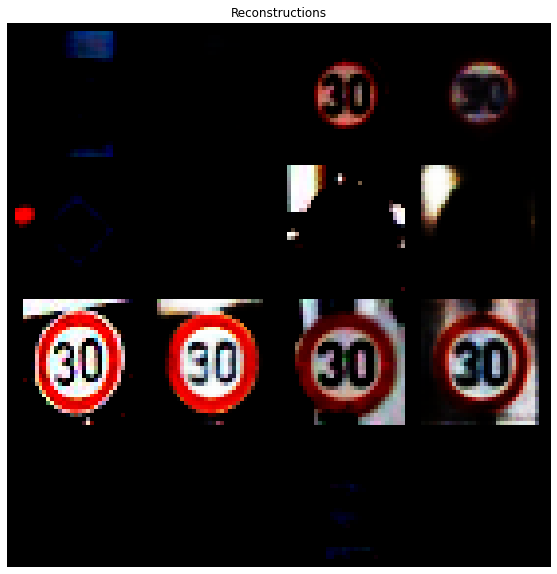

In [123]:
input_imgs = get_train_images(8)
visualize_reconstructions(vae, input_imgs, device)

# Generating new images

In [124]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()
    
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

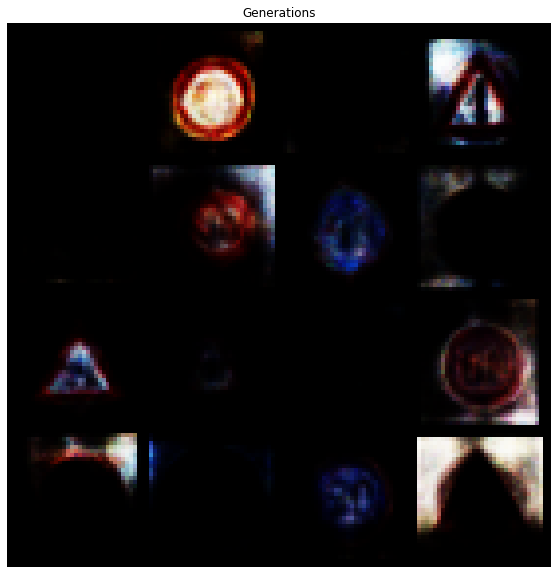

In [125]:
generate_images(vae, 16 , device)

# Hidden layer VAE

In [126]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    labels = []
    for imgs, label in data_loader:
        with torch.no_grad():
            mean, var_log = model.encoder(imgs.to(device))
        img_list.append(imgs)
        embed_list.append(mean)
        labels.append(label)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0), torch.cat(labels, dim=0))


In [127]:
import umap
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [128]:
umap_object = umap.UMAP(metric="cosine", n_neighbors=100)
train_img_embeds = embed_imgs(vae, trainloader)
test_img_embeds = embed_imgs(vae, validloader)
train_embedded = umap_object.fit_transform(train_img_embeds[1][:5000].cpu())

In [129]:
def plot_latent(train_embedded, train_img_embeds, n_data=5000):
    data = pd.DataFrame(train_embedded[:n_data])
    data["label"] = train_img_embeds[2][:n_data].cpu().numpy()
    examples = []
    examples_locations = []
    for i in np.random.randint(0,n_data,40):
        examples.append(train_img_embeds[0][i].squeeze(0).cpu().numpy())
        examples_locations.append(data.iloc[i])
    fig, ax = plt.subplots(figsize=(12, 10))
    # ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
    sns.scatterplot(
        x=0, y=1,
        hue="label",
        palette=sns.color_palette("hls", 43),
        data=data,
        legend="full",
        alpha=0.1
    )
    for location, example in zip(examples_locations, examples):
        x, y = location[0], location[1]
        label = int(location["label"])
        print(example.shape)
        ab = AnnotationBbox(OffsetImage(example,cmap=plt.cm.gray_r, zoom=1), (x, y), frameon=True,
                            bboxprops=dict(facecolor=sns.color_palette("hls", 43)[label], boxstyle="round"))
        ax.add_artist(ab)
    plt.show()

In [130]:
# plot_latent(train_embedded, train_img_embeds)

<AxesSubplot:xlabel='0', ylabel='1'>

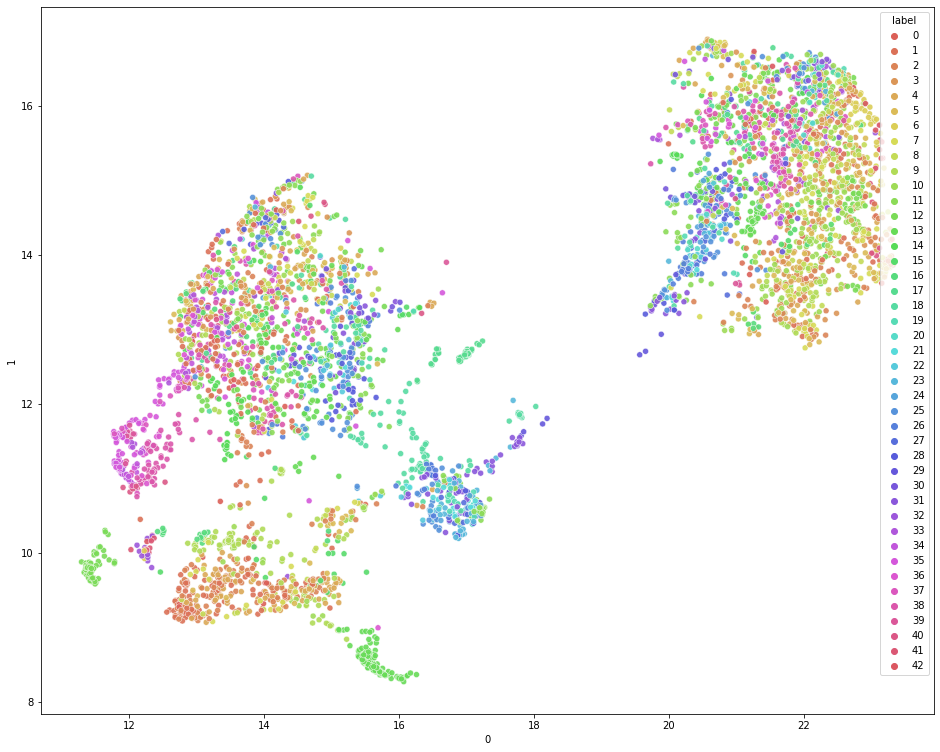

In [131]:
data = pd.DataFrame(train_embedded[:5000])
data["label"] = train_img_embeds[2][:5000].cpu().numpy()
fig, ax = plt.subplots(figsize=(16, 13))
# ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
sns.scatterplot(
    x=0, y=1,
    hue="label",
    palette=sns.color_palette("hls", 43),
    data=data,
    legend="full",
    alpha=0.9
)

# Evaluation - Frechet Inception distance

In [132]:
import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [133]:
class Evaluator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Evaluator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 50)
        self.fc_out  = nn.Linear(50, 10)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def get_features(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        return x
    

    def forward(self, x):
        x = self.get_features(x)
        x = self.fc_out(x)
        return x

evaluator = Evaluator(32*32*3, 256).to(device)

In [134]:
orig_data = [x[0] for x in list(val_ds)[:1000]]
orig_data = torch.stack(orig_data)

In [135]:
with torch.no_grad():
    latent_dim=64
    fixed_noise = torch.randn(1000, latent_dim, device=device)
    generations_vae = vae.decoder(fixed_noise)
    torch.nn.functional.normalize(generations_vae, p=2.0, dim = 2, )
    
    dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()
    dist_vae = evaluator.get_features(generations_vae.to(device)).cpu()

In [136]:
orig_data_2 = [x[0] for x in list(val_ds)[-1000:]]
orig_data_2 = torch.stack(orig_data_2)
with torch.no_grad():
    dist_orig_data_2 = evaluator.get_features(orig_data_2.to(device)).cpu()

In [137]:
for name, obj in zip(['orig','vae'],[dist_orig_data_2.numpy(), dist_vae.numpy()]):
    print(f"FD {name}: {calculate_frechet_distance(dist_orig_data.numpy(),obj)}")

FD orig: 0.0070465369880237105
FD vae: 0.4961029737568947


# Saving generated images to file

In [138]:
torch.save(generations_vae.cpu().detach(), "poniedzialek_Lopatto_Sakowski.pt")

In [139]:
generations_vae[7].max()

tensor(0.7262, device='cuda:0')

In [140]:
generations_vae[0].min()

tensor(2.0319e-11, device='cuda:0')